## Backpropagation and Neural Networks
In class we have learned backpropagation algorithm and neural networks. In this section, we will build a simple neural network and use packpropagation algorithm to train the model to fit an arbitrary function. We are going to use `numpy` and `matplotlib` in Python, first let us import these packages.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Our experiment consists of three steps:
1. Model implementation, including linear layer, several activation functions and MSE-loss.
2. Generate training set and train our model. 
3. Analytical questions and bonus.

You need to write some codes and answer some analytical questions during our experiment.

### Model implementation
#### Basic knowledge
A neural network may consist of multiple layers, which includes input layer, output layer and multiple hidden layers. 
Each layer could do both forward propagation and backward propagation. Now, assume current layer is the $l$-th layer, and we denote current layer as a function $f(X, W)$, where $X$ is the input data and $W$ is the weights. *Note that some types of layers don't have weights, which means they don't need to be updated.

In forward propagation, the layer takes input data $X$ and computes the output $Y = f(X, W)$, which will be used as input data of $(l+1)$-th layer. 

Backward propagation is a little more complicated. Denote the loss function of model as $\mathcal L$. In backward propagation, we firstly receive a output gradient $\frac{\partial \mathcal L}{\partial f}$ which is passed from the $(L+1)$-th layer. What we want is to compute the gradients of $X$ and $W$. According to the chain rule, we have:
$$
\frac{\partial \mathcal L}{\partial X} = \frac{\partial \mathcal L}{\partial f}\frac{\partial f}{\partial X},
\frac{\partial \mathcal L}{\partial W} = \frac{\partial \mathcal L}{\partial f}\frac{\partial f}{\partial W}.
$$
Further, $\frac{\partial \mathcal L}{\partial X}$ will be backward-passed to the $(l-1)$-th layer, and $\frac{\partial \mathcal L}{\partial W}$ can be used to update the weights.

#### Base class
Because all layers need to do forward propagation and backward propagation, we will define a base class first. All kinds of other layers will be derived from this class. 

In [2]:
class Module:
    def __init__(self):
        self.with_weights = False
        pass
    def forward(self):
        pass
    def backward(self):
        pass
    def __call__(self, *inputs, **kwargs):
        return self.forward(*inputs, **kwargs)
# learning rate

Note that we define the `__call__` method, which make the class callable. This means we can call the object of `Module` class like a function:
```py
model = Module()
# equavilent to model.__call__()
model()
```
In `__call__` function, we pass the parameters to `forward` function and return the results. So we could write *pytorch*-style code and do forward propagation by call the object. 
```py
# forward propagation
# equavilent to model.forward(input)
model(input)
```
#### Linear layer
A linear unit applies a linear transformation to the incoming data:
$$
\mathbf y =  \boldsymbol w^T \boldsymbol x + b,
$$
where $\boldsymbol x \in \mathbb R^{n}$ is the input array, $\boldsymbol w \in \mathbb R^{n}$ is the weight and $b \in \mathbb R$ is the bias. Here, $n$ is the input dimension. 

![](./fig1.png) 

A linear layer consists of multiple linear units, the number of linear units also determines the output dimension:

![](./fig2.png) 

We use $W \in \mathbb R ^{n\times k}, \mathbf b \in \mathbb R^{1 \times k}$ to denote the weight and bias of linear layer respectively, where $W  = \left[\boldsymbol w^{(1)},..., \boldsymbol w^{(k)}\right], \mathbf b = \left[ b^{(1)},...,b^{(k)} \right]$. The forward propagation of linear layer can be formulated as:
$$
\mathbf y = XW + \mathbf b,
$$
where $X \in \mathbb R^{m \times n}$ is the input array, $y \in \mathbb R ^{m \times k}$ is the output array. Here $m$ is the batch size, so we can compute a whole batch of samples together. 

For backward propagation, we have received an output gradient $\frac{\partial \mathcal L}{\partial Y}$, which is a $m \times k$ matrix. And we have:
$$
\frac{\partial \mathcal L}{\partial W} = X^T \frac{\partial \mathcal L}{\partial Y}, \quad \frac{\partial \mathcal L}{\partial \mathbf b} = \mathbf 1^T \frac{\partial \mathcal L}{\partial Y}, \quad \frac{\partial \mathcal L}{\partial X}= \frac{\partial \mathcal L}{\partial Y} W^T,
$$
where $\mathbf 1 \in \mathbb R^m$ is a vector with all elements equal to $1$. 
For detailed derivation, refer to [Backpropagation for a Linear Layer](http://cs231n.stanford.edu/handouts/linear-backprop.pdf).

**Q1. Implement the forward propagation and backward propagation of linear layer.**

In [3]:
class Linear(Module):
    def __init__(self,input_dim,output_dim):
        super(Linear, self).__init__()
        # initilize weights
        self.W = np.random.randn(input_dim, output_dim) * 1e-2
        self.b = np.zeros((1, output_dim))
        self.with_weights = True
    def forward(self, input_array):
        res = np.zeros((input_array.shape[0], self.W.shape[1]))
        
        ## start of your code
        res = input_array @ self.W + self.b
        ## end of your code
        
        return res
    def backward(self, input_array, output_gradient, lr = 0.05):
        res = np.zeros_like(input_array)
        
        ## start of your code
        # 1. compute new output_gradient, which will be backward-passed to previous layer
        res = np.dot(output_gradient, self.W.T)
        # 2. compute the gradient and update W, b
        self.W = self.W - lr * np.dot(input_array.T, output_gradient)
        self.b = self.b - lr * np.dot( np.ones((1, input_array.shape[0])), output_gradient)
        ## end of your code
        return res

Here, we will use a simple example to test our code. We set $m = n = k = 2$, $X = \begin{bmatrix}2 & 3\\4 & 5\end{bmatrix}$, $W = \begin{bmatrix}1 & 2\\1 & 2\end{bmatrix}$, $\mathbf b = \mathbf 0^T$, $\frac{\partial \mathcal L}{\partial Y}= \begin{bmatrix}1 & 1\\1 & 1\end{bmatrix}$. 

For forward propagation, you should get a result:
$$
XW + b = \begin{bmatrix}2 & 3\\4 & 5\end{bmatrix} \begin{bmatrix}1 & 2\\1 & 2\end{bmatrix} + \mathbf 0^T =  \begin{bmatrix}5 & 10\\9 & 18\end{bmatrix}
$$

For backward propagation, you should get a reult:
$$
\frac{\partial \mathcal L}{\partial X} = \frac{\partial \mathcal L}{\partial Y} W^T = \begin{bmatrix}1 & 1\\1 & 1\end{bmatrix} \begin{bmatrix}1 & 1\\2 & 2\end{bmatrix} = \begin{bmatrix}3 & 3\\3 & 3\end{bmatrix}.
$$
And the updated parameters should be (here, learning rate is set as $0.05$):
$$
W := W - \alpha \frac{\partial \mathcal L}{\partial W} = W - \alpha X^T \frac{\partial \mathcal L}{\partial Y} = \begin{bmatrix}1 & 2\\1 & 2\end{bmatrix} - 0.05 \cdot \begin{bmatrix}2 & 4\\3 & 5\end{bmatrix}\begin{bmatrix}1 & 1\\1 & 1\end{bmatrix} = \begin{bmatrix}0.7 & 1.7\\0.6 & 1.6\end{bmatrix}\\
\mathbf b := \mathbf b - \alpha \frac{\partial \mathcal L}{\partial \mathbf b} =\mathbf b - \alpha \mathbf{1}^T \frac{\partial \mathcal L}{\partial Y} = \begin{bmatrix}0 & 0\end{bmatrix}- 0.05 \cdot \begin{bmatrix}1 & 1\end{bmatrix} \begin{bmatrix}1 & 1\\1 & 1\end{bmatrix} = \begin{bmatrix}-0.1 & -0.1\end{bmatrix}
$$

In [4]:
test_linear = Linear(2, 2)
input_array = np.array([[2., 3.],[4., 5.]])
test_linear.W = np.array([[1., 2.], [1., 2.]])
forward_res = test_linear(input_array)
print("forward:\n", forward_res)
# output dimension
output_gradient =  np.ones((2,2))
backward_res = test_linear.backward(input_array, output_gradient, lr=0.05)
print("backward:\n", backward_res)
print("W:\n", test_linear.W)
print("b:\n", test_linear.b)

forward:
 [[ 5. 10.]
 [ 9. 18.]]
backward:
 [[3. 3.]
 [3. 3.]]
W:
 [[0.7 1.7]
 [0.6 1.6]]
b:
 [[-0.1 -0.1]]


#### Activation layer
We will implement two types of activation layers. Activation layers do not change the dimension of input array. Given an activation function, the activation layer will apply the activation function on each element of the input array and get the output that has a same shape with input array. Also, we don't need to update the parameter.

![](./fig3.png)

##### ReLU
ReLU is an activation function defined as the positive part of its argument:
$$
\text{R}(x) = x^+ = \max(0, x).
$$
We have:
$$
\text{R}'(x) = \left\{\begin{matrix}1&x > 0\\0 & \text{otherwise}\end{matrix}\right.
$$
So for backward propagation of ReLU layer, if the input element is negative, the corresponding element in output gradient $\frac{\partial \mathcal L}{\partial Y}$ will be set to $0$, other elements will stay the same.

**Q2. Implement the foroward propagation and backward propagation of ReLU layer.**

In [5]:
class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()
        pass
    def forward(self, input_array):
        res = np.zeros_like(input_array)
        
        ## start of your code
        res = (np.abs(input_array) + input_array) / 2
        ## end of your code
        
        return res
    def backward(self, input_array, output_gradient):
        res = np.zeros_like(input_array)
        ## start of your code
        res = (input_array > 0) * output_gradient
        ## end of your code
        return res

To test ReLU layer, we set input $X = \begin{bmatrix}2 & -2\\-2 & 2\end{bmatrix}$, $\frac{\partial \mathcal L}{\partial Y}= \begin{bmatrix}1 & 1\\1 & 1\end{bmatrix}$. 

For forward propagation, we have a result: 
$$
\text{R}(X) =  \begin{bmatrix}2 & 0\\0 & 2\end{bmatrix}.
$$
For backward propagation, we have a result:
$$
\frac{\partial \mathcal L}{\partial X} =  \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}.
$$

In [6]:
test_relu = ReLU()
input_array = np.array([[2., -2.],[-2., 2]])
forward_res = test_relu(input_array)
print("forward:\n", forward_res)
output_gradient =  np.ones((2,2))
backward_res = test_relu.backward(input_array, output_gradient)
print("backward:\n", backward_res)

forward:
 [[2. 0.]
 [0. 2.]]
backward:
 [[1. 0.]
 [0. 1.]]


##### Sigmoid
Sigmoid function is an activation function defined by the formula:
$$
\text{S}(x) = \frac{1}{1 + e^{-x}}.
$$
We have
$$
\text{S}'(x) =\text{S}(x) \left(1 - \text{S}(x)\right)
$$
So for backward propagation of Sigmoid layer, we compute $\text{S}'(x)$ for each input element $x$ and multiply it with the corresponding element in output gradient $\frac{\partial \mathcal L}{\partial Y}$.

**Q3. Implement the forward propagation and backward propagation of Sigmoid layer.**

In [7]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()    
        pass
    def forward(self, input_array):
        res = np.zeros_like(input_array)
        
        ## start of your code
        res = 1 / (1+np.exp(-input_array))
        ## end of your code
        
        return res
    def backward(self, input_array, output_gradient):
        res = np.zeros_like(input_array)
        
        ## start of your code
        tmp = np.exp(-input_array)
        res = (1 / (1+tmp)) * (tmp / (1+tmp)) * output_gradient
        ## end of your code
        
        return res  

To test Sigmoid layer, we set input $X = \begin{bmatrix}2 & -2\\-2 & 2\end{bmatrix}$, $\frac{\partial \mathcal L}{\partial Y}= \begin{bmatrix}1 & 1\\1 & 1\end{bmatrix}$. 

For forward propagation, we have a result: 
$$
\text{S}(X) =  \begin{bmatrix}0.88079708 &0.26894142\\0.26894142 & 0.88079708\end{bmatrix}.
$$
For backward propagation, we have a result:
$$
\frac{\partial \mathcal L}{\partial X} =  \begin{bmatrix}0.10499359 & 0.19661193\\0.19661193 & 0.10499359\end{bmatrix}.
$$

In [8]:
test_sigmoid = Sigmoid()
input_array = np.array([[2., -1.],[-1., 2]])
forward_res = test_sigmoid(input_array)
print("forward:\n", forward_res)
output_gradient =  np.ones((2,2))
backward_res = test_sigmoid.backward(input_array, output_gradient)
print("backward:\n", backward_res)

forward:
 [[0.88079708 0.26894142]
 [0.26894142 0.88079708]]
backward:
 [[0.10499359 0.19661193]
 [0.19661193 0.10499359]]


#### MSELoss
To train our model, we need to define our loss function.Because we want to do a regression problem, we will use mean squared error (MSE) as our loss function:
$$
\text{MSE} = \frac{1}{m}\sum_{i=1}^m\left(\hat y^{(i)} - y^{(i)}\right)^2
$$
Loss can be considered as a special layer. In forward propagation, it takes the predicted value and true value as input and returns the error. For backward propagation, it will compute the gradients of output layer. Note that we don't need a output gradient here, because it's the final layer in training process.

**Q4. Implement the forward propagation and backward propagation of MSELoss layer.**

In [9]:
class MSELoss(Module):
    def __init__(self):
        super(MSELoss, self).__init__()   
        pass
    def forward(self, predicted_y, y):
        res = 1e5
        
        ## start of your code
        res = np.sum(np.power(predicted_y - y, 2)) / y.shape[0]
        ## end of your code
        
        return res
    def backward(self, predicted_y, y):
        
        ## start of your code
        res = 2 * (predicted_y - y) / y.shape[0] 
        ## end of your code
        
        return res

To test MSELoss, we set predicted value $\hat{ \mathbf y} = \begin{bmatrix}1 \\1\end{bmatrix}$ and true value $\mathbf y = \begin{bmatrix}1.5 \\1.5\end{bmatrix}$. 

For forward propagation, we have a result: 
$$
\text{MSE}  =  0.25.
$$
For backward propagation, we have a result:
$$
\frac{\partial \mathcal L}{\partial \hat{ \mathbf y}} =  \begin{bmatrix}-0.5 \\ -0.5\end{bmatrix}.
$$

In [10]:
test_mse = MSELoss()
pred_y = np.array([[1], [1]])
true_y = np.array([[1.5], [1.5]])
forward_res = test_mse(pred_y, true_y)
print("forward:\n", forward_res)
backward_res = test_mse.backward(pred_y, true_y)
print("backward:\n", backward_res)

forward:
 0.25
backward:
 [[-0.5]
 [-0.5]]


#### Simple Neural Network
By now, we can actually design a neural network with all these layers and loss function. Here, we define a new class to connect all the components.  You just need to list all the layers you want to use by order, and input the list and loss function when construct the model. 

In `forward` function, we will start from the first layer, which takes the original features as input, and the output will be the input data for the next layer. We use a for-loop for forward propagation. All the intermediate input array will be stored for later backward propagation. 

In `backword` function, we firstly compute the loss and output gradient generated from loss function. Then, this output gradient will be passed to output layer. Start from the output layer, we update the parameters and backward-pass the output gradient to previous layers through a reversed for-loop. 

Therefore, by calling `forward` and `backward`, our model will automatically do the propagation and update parameters. However, you need to make sure your design is reasonable. *If the dimensions between different layers don't match, there will be errors.*

In [11]:
class SimpleNN(Module):
    def __init__(self, layers, loss, lr = 0.005):
        super(SimpleNN, self).__init__()    
        self.layers = layers
        self.loss = loss
        self.inputs = [None for _ in range(len(self.layers))]
        self.output = None
        self.loss_value = 1e5
        self.lr = lr
        pass
    def forward(self, input_array):
        current_input = input_array
        for i in range(len(self.layers)):
            self.inputs[i] = current_input
            current_input = self.layers[i](current_input)
        self.output = current_input
        return self.output
    def backward(self, y):
        if self.inputs[-1] is None:
            print("call forward first.")
            return
        self.loss_value = self.loss(self.output, y)
        output_gradient = self.loss.backward(self.output, y)
        for i in range(len(self.layers)-1, -1, -1):
            if self.layers[i].with_weights:
                output_gradient = self.layers[i].backward(self.inputs[i], output_gradient, self.lr)
            else:
                output_gradient = self.layers[i].backward(self.inputs[i], output_gradient)
        self.output = None

### Train the model
Here, we will design a simple neural network. The structure of our model is shown in following figure:

![](./fig4.png)
Our model contains:
- L0, Input layer (shape: $N \times 1$), where $N$ is the batch size.
- L1, Linear layer (shape: $1 \times 80$)
- L2, ReLU layer
- L3, Linear layer (shape: $80 \times 80$)
- L4, ReLU layer
- L5, Output layer (linear layer, shape: $80 \times 1$)

In [12]:
layers = [
    # input layer is input data
    # L1
    Linear(1, 80),
    # L2
    ReLU(),
    # L3
    Linear(80, 80),
    # L4
    ReLU(),
    # L5
    Linear(80, 1)
]
loss = MSELoss()
model = SimpleNN(layers, loss, lr=0.05)

We use this model to approximate the sine function. Our training set $\left\{x^{(i)}, y^{(i)}: i=1,2, \ldots, m\right\}$ is generated by 
$$
y^{(i)}=\sin x^{(i)}, \quad \forall i.
$$

In [13]:
x = np.linspace(-np.pi, np.pi, 100).reshape(-1, 1) 
y = np.sin(x)

Now, train our model and plot the results.

epoch 0/20000, loss: 0.4950344386374714
epoch 500/20000, loss: 0.10912409617317062
epoch 1000/20000, loss: 0.032890544200878766
epoch 1500/20000, loss: 0.004604287899363108
epoch 2000/20000, loss: 0.0012845106453208402
epoch 2500/20000, loss: 0.0005281073091203445
epoch 3000/20000, loss: 0.00027648723912179274
epoch 3500/20000, loss: 0.0001599745874893538
epoch 4000/20000, loss: 0.00010404300176009772


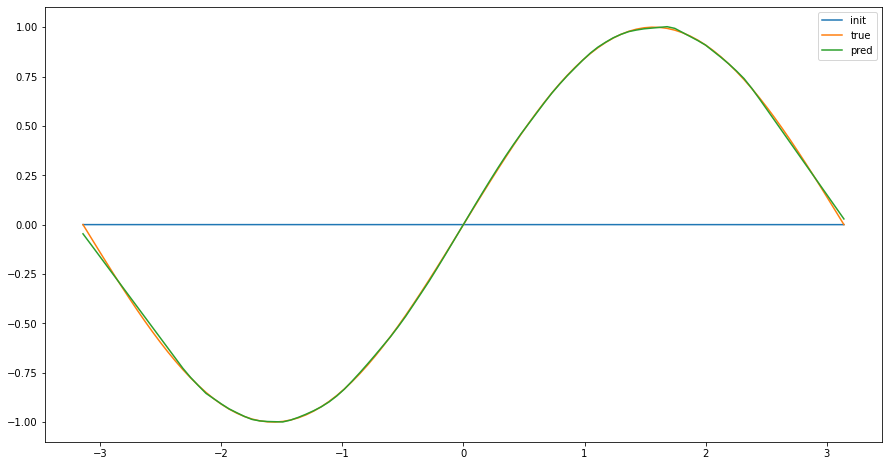

In [14]:
epoch = 0
max_iteration = 20000
plt.figure(figsize=(15, 8))
pred_y = model(x)
plt.plot(x, pred_y, label="init")
plt.plot(x, y, label="true")
while epoch < max_iteration and model.loss_value > 1e-4:
    pred_y = model(x)
    model.backward(y)
    if epoch % 500 == 0:
        print(r'epoch {}/{}, loss: {}'.format(epoch, max_iteration, model.loss_value))
    epoch += 1
plt.plot(x, pred_y, label="pred")
plt.legend()

### Analytical questions and bonus
**Q4. Try to use Sigmoid as the activation function. Change the size of dataset and compare the training speed and results.**

**Your answer:**

**Q5. Try to remove all the activation layers. Compare the results and analyze the role of activation layers.**

**Your answer:**

### Bonus
**Q6. Add L2 regularization for linear layer.**

**Q7. We have learned logistic regression for binary classification task, here we can actually build a network for the same task. The output of Sigmoid layer can be considered as probability, and we have Logistic loss:**
$$
\text{Logistic} = - \frac{1}{m}\sum_{i=1}^m y^{(i)}\log p^{(i)}+ \left(1 -  y^{(i)}\right)\log\left(1 - p^{(i)}\right)
$$
**Now, implement Logistic loss.** 

In [15]:
class LogisticLoss(Module):
    def __init__(self):
        super(LogisticLoss, self).__init__()   
        pass
    def forward(self, pred_prob, y):
        res = 1e7
        pred_prob += 1e-5 * (pred_prob == 0)
        
        ## start of your code
#         res = -( np.sum(y * np.log( pred_prob)) + np.sum((1 - y) * np.log(1 - pred_prob)))/ y.shape[0]
        res = -(1/y.shape[0]*np.sum(np.multiply(y, np.log(pred_prob)) + np.multiply((1 - y), np.log(1 - pred_prob))))
        ## end of your code
        
        return res 
    def backward(self, pred_prob, y):
        res = np.zeros_like(input_array)
        pred_prob += 1e-5 * (pred_prob == 0)
        
        ## start of your code
#         res = - (y / pred_prob -(1-y) / (1 - pred_prob)) / y.shape[0]
        res = -(1/y.shape[0] * (y/pred_prob - (1-y) / (1 - pred_prob)))
        ## end of your code
        
        return res

We can re-use previous functions in `logistic_regression.ipynb` to generate our classification dataset. The number of feature is set to $1$.

In [16]:
# functions in logistic_regression.ipynb
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def predict_probability(X, theta):
    return sigmoid(X@theta)
def predict_label(X, theta):
    return (predict_probability(X, theta) > 0.5).astype(float)
def generate_binary_classification_data(num_samples, theta, bias = True):
    if bias == False:
        X = (np.random.rand(num_samples, theta.shape[0]) - 0.5) * 4
    else:
        # place the center of X on (-bias)
        X = (np.random.rand(num_samples, theta.shape[0] - 1) - 0.5) * 4 - theta[-1]
        # add another dimension for bias
        X = np.insert(X, X.shape[1], 1, axis=1)
    y = predict_label(X, theta)
    return X, y
theta_ = np.array([1, 1])
x, y = generate_binary_classification_data(100, theta_, True)
x = np.delete(x, -1, axis=1) 
y = y.reshape((-1, 1))

Now, build a network for binary classification problem. The output layer is a Sigmoid layer.

In [17]:
layers = [
    Linear(1, 80),
    Linear(80, 1),
    Sigmoid()
]

loss = LogisticLoss()
model = SimpleNN(layers, loss, lr = 0.001)

Finally, train the model and visualize the results.

epoch 0/20000, loss: 0.6931024050901361
epoch 500/20000, loss: 0.6893755766194988
epoch 1000/20000, loss: 0.6854984786491233
epoch 1500/20000, loss: 0.6806988215155306
epoch 2000/20000, loss: 0.6740296931304726
epoch 2500/20000, loss: 0.6642690193565344
epoch 3000/20000, loss: 0.6499329232293718
epoch 3500/20000, loss: 0.6295372100029659
epoch 4000/20000, loss: 0.6022240217280707
epoch 4500/20000, loss: 0.5685642790403175
epoch 5000/20000, loss: 0.5308195222147797
epoch 5500/20000, loss: 0.4920702583143065
epoch 6000/20000, loss: 0.45484879631795816
epoch 6500/20000, loss: 0.42049717866429687
epoch 7000/20000, loss: 0.38941454158098354
epoch 7500/20000, loss: 0.36153625960133284
epoch 8000/20000, loss: 0.3366381517687933
epoch 8500/20000, loss: 0.3144581737470257
epoch 9000/20000, loss: 0.2947319244948479
epoch 9500/20000, loss: 0.2772021053149362
epoch 10000/20000, loss: 0.26162312261907444
epoch 10500/20000, loss: 0.24776507500758155
epoch 11000/20000, loss: 0.2354169178049403
epoch 

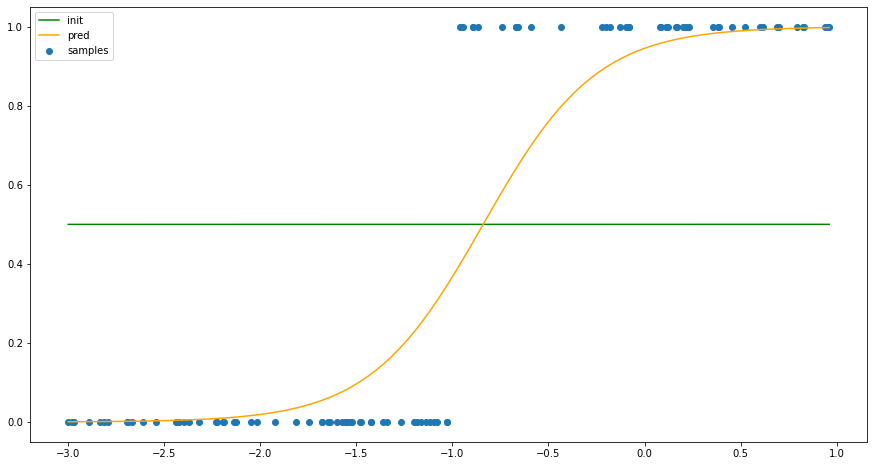

In [18]:
epoch = 0
max_iteration = 20000
plt.figure(figsize=(15, 8))
plt.scatter(x, y, label="samples")
plot_x = np.linspace(np.min(x), np.max(x), 100).reshape((-1, 1))
plt.plot(plot_x, model(plot_x), c="green", label="init")
while epoch < max_iteration:
    model(x)
    model.backward(y)
    if epoch % 500 == 0:
        print(r'epoch {}/{}, loss: {}'.format(epoch, max_iteration, model.loss_value))
    epoch += 1
plt.plot(plot_x, model(plot_x), c="orange", label="pred")
plt.legend()